In [1]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI

In [2]:
llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

In [ ]:
from openai import OpenAI
client = OpenAI()

response = client.chat.completions.create(
  model="gpt-4o",
  messages=[],
  temperature=1,
  max_tokens=256,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
)

In [46]:
loader = TextLoader('docs/physics.txt')
physics_docs = loader.load()

In [54]:
print(physics_docs[0].page_content)

1. Albert Einstein developed the theory of relativity, which revolutionized theoretical physics and astronomy.

2. The theory of relativity was formulated in the early 20th century and has had a profound impact on our understanding of space and time.

3. Isaac Newton, known for his laws of motion and universal gravitation, laid the groundwork for classical mechanics.

4. In 1915, Einstein presented the general theory of relativity, expanding on his earlier work on special relativity.

5. Newtonâ€™s work in the 17th century provided the foundation for much of modern physics.


In [57]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=300)
p_docs_split = text_splitter.split_documents(physics_docs)

In [10]:
embeddings = OpenAIEmbeddings()

In [58]:
db = FAISS.from_documents(p_docs_split, embeddings)

In [59]:
retriever = db.as_retriever()

### Using RAG

In [13]:
question = "How did the scientific contributions of the 17th century influence early 20th-century physics?"

qa_chain = RetrievalQA.from_chain_type(llm,retriever=retriever)
response - qa_chain.invoke(question)['result'])
print(response)

The scientific contributions of the 17th century, particularly those of Isaac Newton, laid the groundwork for much of modern physics and significantly influenced early 20th-century physics. Newton's laws of motion and universal gravitation established the principles of classical mechanics, which provided a comprehensive framework for understanding the physical world. These principles were foundational for the development of later theories and experiments.

In the early 20th century, Albert Einstein built upon this foundation with his theory of relativity. While Newton's laws were highly successful in describing the motion of objects at everyday speeds and scales, they were found to be inadequate for explaining phenomena at very high speeds and in strong gravitational fields. Einstein's special theory of relativity, introduced in 1905, and his general theory of relativity, presented in 1915, expanded on Newtonian mechanics by incorporating the effects of high velocities and gravity on s

### Using GraphRAG

In [14]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
llm_transformer = LLMGraphTransformer(llm=llm)

In [60]:
from langchain_core.documents import Document
documents = []
for p in range(len(docs)):
    documents.append(Document(page_content=docs[p].page_content))
graph_documents = llm_transformer.convert_to_graph_documents(documents)

In [17]:
from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import RDF, RDFS, OWL, XSD, SKOS, NamespaceManager
import os

def add_graph_documents(graph_documents, base_iri, kg_uri, output_file, ontology_file=None):
    g = Graph()
    # Define namespaces
    prefixes = {
        'xsd': XSD,
        'rdf': RDF,
        'rdfs': RDFS,
        'owl': OWL,
        'dct': Namespace('http://purl.org/dc/terms/'),
        'skos': SKOS,
        'cmns-av': Namespace('https://www.omg.org/spec/Commons/AnnotationVocabulary/'),
        'ct': Namespace(base_iri)
    }
    for p, ns in prefixes.items():
        g.bind(p, ns)
    if ontology_file is not None:
        g.parse(ontology_file)
        
    prefix = base_iri
    g.add((URIRef(kg_uri), RDF.type, OWL.Ontology))
    
    for docs in graph_documents:
        for node in docs.nodes:
            subject = URIRef(prefix + (node.id.replace(' ', '_').replace('>','gt_').replace('<','lt_')))
            subject = URIRef(subject.replace("\(","").replace("\)",""))
            #literal_object = Literal(node.type) 
            object = URIRef(prefix + node.type.replace(' ', '_').replace('>','gt_').replace('<','lt_'))
            object = URIRef(object.replace("\(","").replace("\)",""))
            if (object, RDF.type, OWL.Class) not in g:
                g.add((object, RDF.type, OWL.Class))
           # g.add((object, RDFS.label, literal_object))
            g.add((subject, RDF.type, object))

        for rel in docs.relationships:
            subject = URIRef(prefix + (rel.source.id.replace(' ', '_').replace('>','gt_').replace('<','lt_')))
            subject = URIRef(subject.replace("\(","").replace("\)",""))
            domain = URIRef(prefix + rel.source.type.replace(' ', '_'))
            range = URIRef(prefix + rel.target.type.replace(' ', '_'))
            #predicate_label = Literal(rel.type)
            predicate = URIRef(prefix + rel.type.replace(' ', '_'))
            #literal_object = Literal(rel.target.type)
            object = URIRef(prefix + (rel.target.id.replace(' ', '_').replace('>','gt_').replace('<','lt_')))
            object = URIRef(object.replace("\(","").replace("\)",""))
            if (predicate, RDF.type, OWL.ObjectProperty) not in g:
                g.add((predicate, RDF.type, OWL.ObjectProperty))
                g.add((predicate, RDFS.domain, domain))
                g.add((predicate, RDFS.range, range))
         #   g.add((predicate, RDFS.label, predicate_label))
         #   g.add((object, RDFS.label, literal_object))
            g.add((subject, predicate, object))

    if os.path.exists(output_file):
        os.remove(output_file)       
    g.serialize(output_file,format='turtle',prefixes = prefixes, encoding='utf-8')
    return g

In [61]:
rdf_graph = add_graph_documents(graph_documents, 'http://example.org/ex#', 'http://example.org/ex.ttl', 'ttl/ex.ttl')

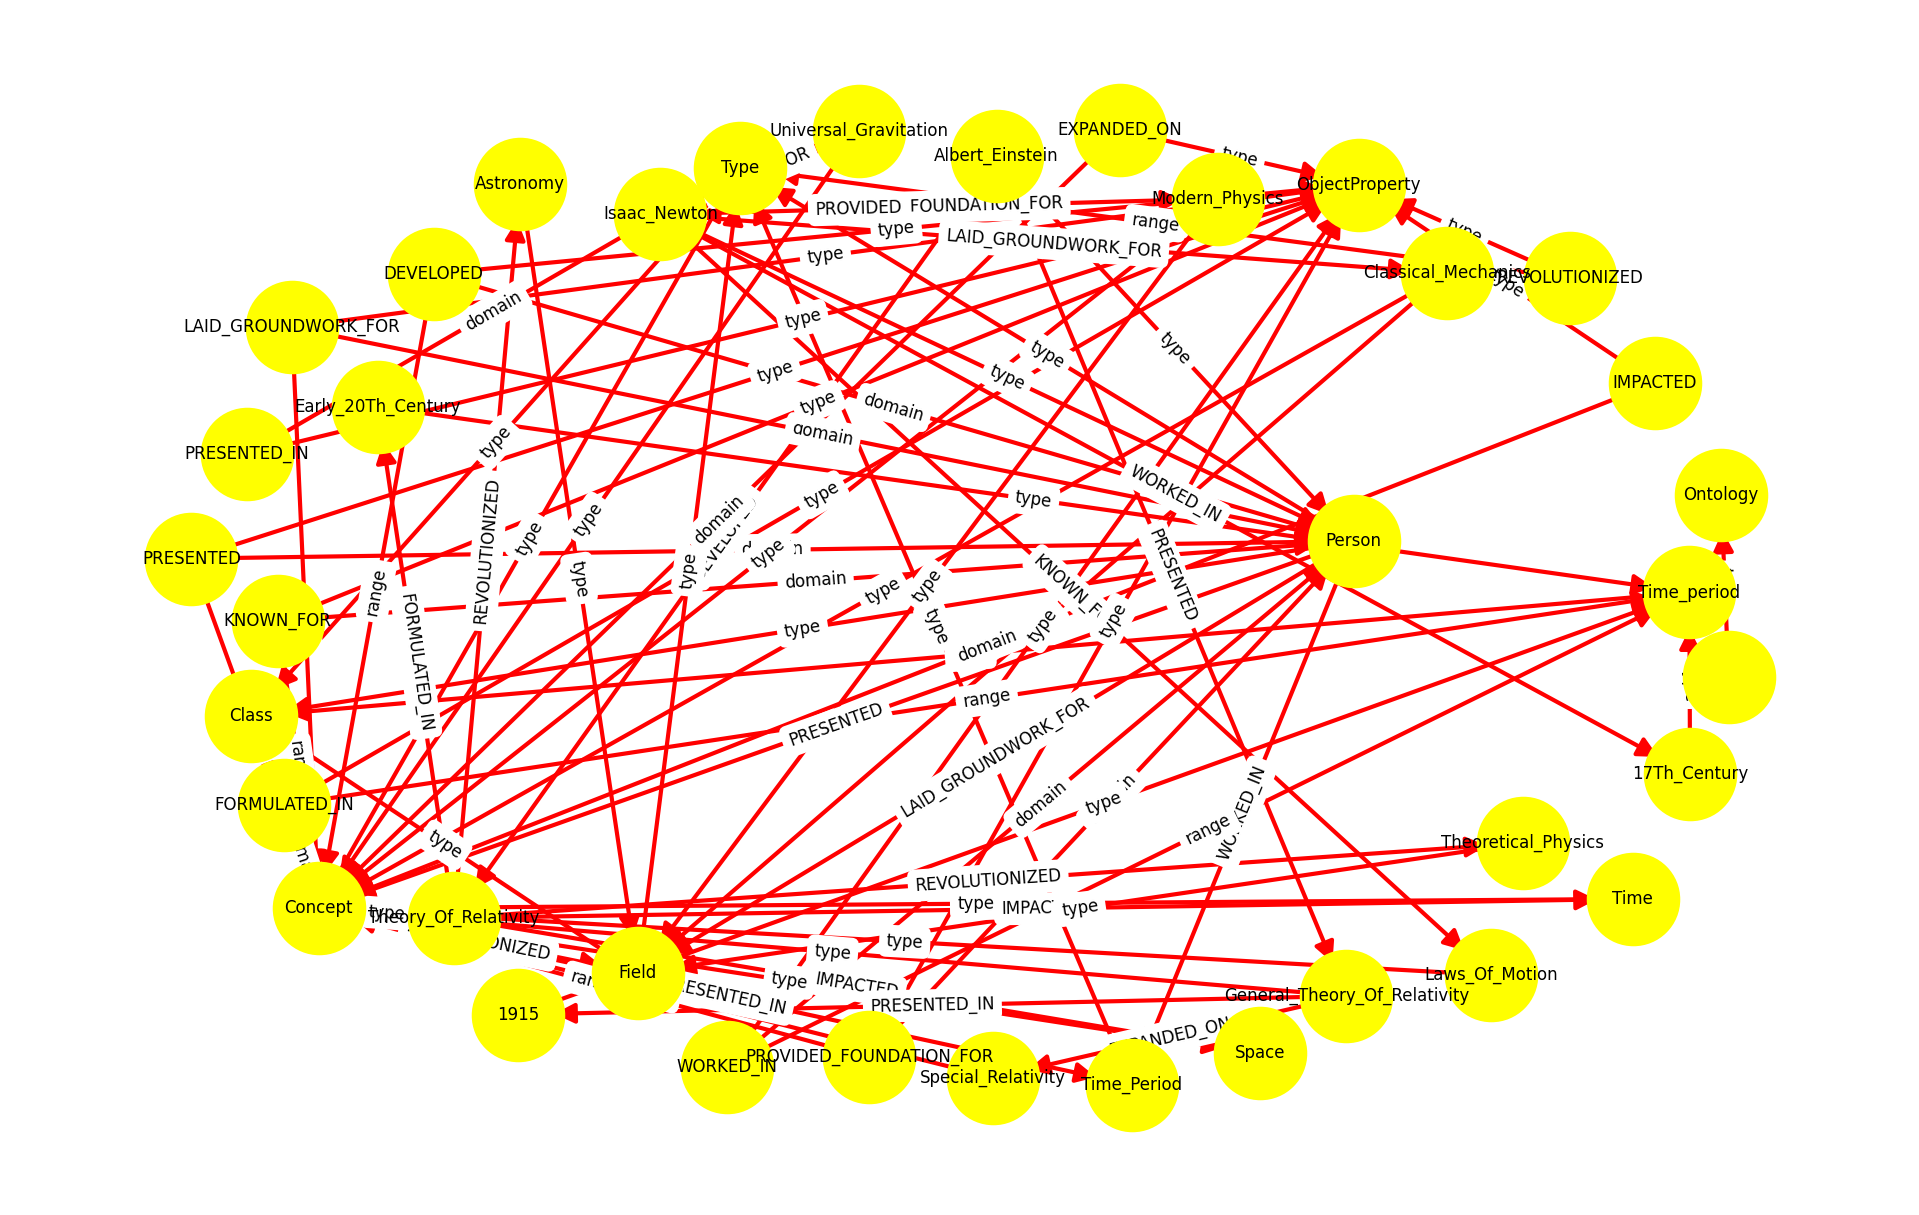

In [62]:
import networkx as nx
import matplotlib.pyplot as plt

# Create graph
G = nx.DiGraph()
G.add_edges_from((source.fragment, target.fragment, 
                  {'relation': relation.fragment}) 
                 for source, relation, target in rdf_graph.triples((None,None,None)))

# Plot the graph
plt.figure(figsize=(8,5), dpi=300)
pos = nx.spring_layout(G, k=3, seed=0)

nx.draw_networkx_nodes(G, pos, node_size=460, node_color='yellow')
nx.draw_networkx_edges(G, pos, edge_color='red')
nx.draw_networkx_labels(G, pos, font_size=4)
edge_labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=4)

# Display the plot
plt.axis('off')
plt.show()

In [63]:
loader = TextLoader("ttl/ex.ttl")
documents = loader.load()

In [64]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.split_documents(documents)

In [65]:
KGvectorstore = FAISS.from_documents(docs, embeddings)
KGretriever = KGvectorstore.as_retriever()

In [66]:
question = "How did the scientific contributions of the 17th century influence early 20th-century physics?" 

KG_qa_chain = RetrievalQA.from_chain_type(llm,retriever=KGretriever)
KG_response = KG_qa_chain.invoke(question)['result']
print(KG_response)

The scientific contributions of the 17th century, particularly those of Isaac Newton, laid the groundwork for developments in early 20th-century physics. Isaac Newton, known for his Laws of Motion and Universal Gravitation, provided the foundation for Classical Mechanics, which in turn provided the basis for Modern Physics. This foundational work was crucial for the development of new theories in the early 20th century, such as Albert Einstein's Theory of Relativity. Einstein's work in Theoretical Physics, including the General Theory of Relativity presented in 1915, revolutionized fields like Astronomy and had a significant impact on concepts of Space and Time. Thus, the advancements in Classical Mechanics during the 17th century were instrumental in enabling the revolutionary theories of the early 20th century.


### Compare the RAG and GraphRAG Responses

In [24]:
from langchain.prompts import ChatPromptTemplate

In [42]:
template = """The following are 2 sections of text. Each section is labled with a number:
1.) """ + response + """
2.) """ + KG_response + """

Use the following pieces of context
to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up answer.
Keep the answer as concise as possible.

Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = ChatPromptTemplate.from_template(template)

In [43]:
from langchain_core.output_parsers import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough
compare_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | QA_CHAIN_PROMPT
    | llm
    | StrOutputParser()
)

In [44]:
print(compare_chain.invoke("Compare the two sections of text and determine if they are similar in content and also explain their differences"))

The two sections of text are similar in content as both discuss the influence of Isaac Newton's 17th-century contributions on early 20th-century physics, particularly highlighting Newton's laws of motion and universal gravitation as foundational for classical mechanics and modern physics. Both sections also mention Albert Einstein's development of the theory of relativity, which expanded on Newtonian mechanics.

The differences are:
1. Section 1 provides more detail on the specific inadequacies of Newton's laws at high speeds and strong gravitational fields and mentions the years Einstein introduced his theories (1905 and 1915).
2. Section 2 is more concise and emphasizes the impact of Einstein's work on fields like Astronomy and Theoretical Physics without specifying the years of his theories.


In [73]:
s = rdf_graph.serialize().strip()

In [74]:
s.split('\n')

['@prefix ct: <http://example.org/ex#> .',
 '@prefix owl: <http://www.w3.org/2002/07/owl#> .',
 '@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .',
 '',
 'ct:Albert_Einstein a ct:Person ;',
 '    ct:DEVELOPED ct:Theory_Of_Relativity ;',
 '    ct:PRESENTED ct:General_Theory_Of_Relativity .',
 '',
 'ct:DEVELOPED a owl:ObjectProperty ;',
 '    rdfs:domain ct:Person ;',
 '    rdfs:range ct:Concept .',
 '',
 'ct:EXPANDED_ON a owl:ObjectProperty ;',
 '    rdfs:domain ct:Concept ;',
 '    rdfs:range ct:Concept .',
 '',
 'ct:FORMULATED_IN a owl:ObjectProperty ;',
 '    rdfs:domain ct:Concept ;',
 '    rdfs:range ct:Time_period .',
 '',
 'ct:IMPACTED a owl:ObjectProperty ;',
 '    rdfs:domain ct:Concept ;',
 '    rdfs:range ct:Concept .',
 '',
 'ct:Isaac_Newton a ct:Person ;',
 '    ct:KNOWN_FOR ct:Laws_Of_Motion,',
 '        ct:Universal_Gravitation ;',
 '    ct:LAID_GROUNDWORK_FOR ct:Classical_Mechanics ;',
 '    ct:PROVIDED_FOUNDATION_FOR ct:Modern_Physics ;',
 '    ct:WORKED_IN ct:17